In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = "MNIST"
model_name = "resnet_ce_mse"
ood = "0:1:2:3:4"

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                            | 0/60000 [00:00<?, ?it/s]

 12%|███████▋                                                      | 7469/60000 [00:00<00:00, 74677.79it/s]

 25%|███████████████▏                                             | 14937/60000 [00:00<00:00, 74554.82it/s]

 37%|██████████████████████▊                                      | 22490/60000 [00:00<00:00, 74998.25it/s]

 50%|██████████████████████████████▍                              | 29990/60000 [00:00<00:00, 71180.72it/s]

 62%|██████████████████████████████████████                       | 37477/60000 [00:00<00:00, 72464.77it/s]

 75%|█████████████████████████████████████████████▊               | 45030/60000 [00:00<00:00, 73481.01it/s]

 87%|█████████████████████████████████████████████████████▎       | 52395/60000 [00:00<00:00, 70737.39it/s]

 99%|████████████████████████████████████████████████████████████▍| 59497/60000 [00:00<00:00, 69084.41it/s]

100%|█████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 71126.87it/s]

  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 75%|██████████████████████████████████████████████▍               | 7493/10000 [00:00<00:00, 74921.14it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 71685.25it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 56bs93uv


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    fpi = 5

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        rcn = x
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            rcn = x
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        rcn = x
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/750 [00:00<?, ?it/s]

  0%|                                                                      | 1/750 [00:00<05:40,  2.20it/s]

  1%|▉                                                                    | 10/750 [00:00<00:32, 23.10it/s]

  3%|█▋                                                                   | 19/750 [00:00<00:18, 39.92it/s]

  4%|██▌                                                                  | 28/750 [00:00<00:13, 52.91it/s]

  5%|███▍                                                                 | 37/750 [00:00<00:11, 62.73it/s]

  6%|████▏                                                                | 46/750 [00:00<00:10, 69.99it/s]

  7%|█████                                                                | 55/750 [00:01<00:09, 75.21it/s]

  9%|█████▉                                                               | 64/750 [00:01<00:08, 78.92it/s]

 10%|██████▋                                                              | 73/750 [00:01<00:08, 81.15it/s]

 11%|███████▌                                                             | 82/750 [00:01<00:08, 83.17it/s]

 12%|████████▎                                                            | 91/750 [00:01<00:07, 84.55it/s]

 13%|█████████                                                           | 100/750 [00:01<00:07, 85.85it/s]

 15%|█████████▉                                                          | 109/750 [00:01<00:07, 86.86it/s]

 16%|██████████▋                                                         | 118/750 [00:01<00:07, 87.57it/s]

 17%|███████████▌                                                        | 127/750 [00:01<00:07, 88.02it/s]

 18%|████████████▎                                                       | 136/750 [00:01<00:06, 88.39it/s]

 19%|█████████████▏                                                      | 145/750 [00:02<00:06, 88.70it/s]

 21%|█████████████▉                                                      | 154/750 [00:02<00:06, 88.87it/s]

 22%|██████████████▊                                                     | 163/750 [00:02<00:06, 89.08it/s]

 23%|███████████████▌                                                    | 172/750 [00:02<00:06, 89.22it/s]

 24%|████████████████▍                                                   | 181/750 [00:02<00:06, 89.25it/s]

 25%|█████████████████▏                                                  | 190/750 [00:02<00:06, 88.91it/s]

 27%|██████████████████                                                  | 199/750 [00:02<00:06, 88.33it/s]

 28%|██████████████████▊                                                 | 208/750 [00:02<00:06, 88.37it/s]

 29%|███████████████████▋                                                | 217/750 [00:02<00:06, 88.57it/s]

 30%|████████████████████▍                                               | 226/750 [00:02<00:05, 88.72it/s]

 31%|█████████████████████▎                                              | 235/750 [00:03<00:05, 88.90it/s]

 33%|██████████████████████                                              | 244/750 [00:03<00:05, 88.85it/s]

 34%|██████████████████████▉                                             | 253/750 [00:03<00:05, 88.86it/s]

 35%|███████████████████████▊                                            | 262/750 [00:03<00:05, 88.98it/s]

 36%|████████████████████████▌                                           | 271/750 [00:03<00:05, 88.95it/s]

 37%|█████████████████████████▍                                          | 280/750 [00:03<00:05, 89.08it/s]

 39%|██████████████████████████▏                                         | 289/750 [00:03<00:05, 89.11it/s]

 40%|███████████████████████████                                         | 298/750 [00:03<00:05, 89.18it/s]

 41%|███████████████████████████▊                                        | 307/750 [00:03<00:04, 89.20it/s]

 42%|████████████████████████████▋                                       | 316/750 [00:04<00:04, 89.16it/s]

 43%|█████████████████████████████▍                                      | 325/750 [00:04<00:04, 89.22it/s]

 45%|██████████████████████████████▎                                     | 334/750 [00:04<00:04, 89.23it/s]

 46%|███████████████████████████████                                     | 343/750 [00:04<00:04, 89.27it/s]

 47%|███████████████████████████████▉                                    | 352/750 [00:04<00:04, 89.31it/s]

 48%|████████████████████████████████▋                                   | 361/750 [00:04<00:04, 89.04it/s]

 49%|█████████████████████████████████▌                                  | 370/750 [00:04<00:04, 88.68it/s]

 51%|██████████████████████████████████▎                                 | 379/750 [00:04<00:04, 88.85it/s]

 52%|███████████████████████████████████▏                                | 388/750 [00:04<00:04, 89.00it/s]

 53%|███████████████████████████████████▉                                | 397/750 [00:04<00:03, 89.09it/s]

 54%|████████████████████████████████████▊                               | 406/750 [00:05<00:03, 89.06it/s]

 55%|█████████████████████████████████████▋                              | 415/750 [00:05<00:03, 89.13it/s]

 57%|██████████████████████████████████████▍                             | 424/750 [00:05<00:03, 89.24it/s]

 58%|███████████████████████████████████████▎                            | 433/750 [00:05<00:03, 88.96it/s]

 59%|████████████████████████████████████████                            | 442/750 [00:05<00:03, 89.02it/s]

 60%|████████████████████████████████████████▉                           | 451/750 [00:05<00:03, 89.11it/s]

 61%|█████████████████████████████████████████▋                          | 460/750 [00:05<00:03, 89.02it/s]

 63%|██████████████████████████████████████████▌                         | 469/750 [00:05<00:03, 89.03it/s]

 64%|███████████████████████████████████████████▎                        | 478/750 [00:05<00:03, 89.08it/s]

 65%|████████████████████████████████████████████▏                       | 487/750 [00:05<00:02, 89.14it/s]

 66%|████████████████████████████████████████████▉                       | 496/750 [00:06<00:02, 88.07it/s]

 67%|█████████████████████████████████████████████▊                      | 505/750 [00:06<00:02, 88.36it/s]

 69%|██████████████████████████████████████████████▌                     | 514/750 [00:06<00:02, 88.49it/s]

 70%|███████████████████████████████████████████████▍                    | 523/750 [00:06<00:02, 88.72it/s]

 71%|████████████████████████████████████████████████▏                   | 532/750 [00:06<00:02, 88.89it/s]

 72%|█████████████████████████████████████████████████                   | 541/750 [00:06<00:02, 88.99it/s]

 73%|█████████████████████████████████████████████████▊                  | 550/750 [00:06<00:02, 89.10it/s]

 75%|██████████████████████████████████████████████████▋                 | 559/750 [00:06<00:02, 89.19it/s]

 76%|███████████████████████████████████████████████████▍                | 568/750 [00:06<00:02, 89.31it/s]

 77%|████████████████████████████████████████████████████▎               | 577/750 [00:06<00:01, 88.84it/s]

 78%|█████████████████████████████████████████████████████▏              | 586/750 [00:07<00:01, 89.00it/s]

 79%|█████████████████████████████████████████████████████▉              | 595/750 [00:07<00:01, 89.23it/s]

 81%|██████████████████████████████████████████████████████▊             | 604/750 [00:07<00:01, 89.29it/s]

 82%|███████████████████████████████████████████████████████▌            | 613/750 [00:07<00:01, 89.38it/s]

 83%|████████████████████████████████████████████████████████▍           | 622/750 [00:07<00:01, 89.40it/s]

 84%|█████████████████████████████████████████████████████████▏          | 631/750 [00:07<00:01, 89.43it/s]

 85%|██████████████████████████████████████████████████████████          | 640/750 [00:07<00:01, 89.39it/s]

 87%|██████████████████████████████████████████████████████████▊         | 649/750 [00:07<00:01, 89.41it/s]

 88%|███████████████████████████████████████████████████████████▋        | 658/750 [00:07<00:01, 89.41it/s]

 89%|████████████████████████████████████████████████████████████▍       | 667/750 [00:07<00:00, 89.41it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 676/750 [00:08<00:00, 89.36it/s]

 91%|██████████████████████████████████████████████████████████████      | 685/750 [00:08<00:00, 89.34it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 694/750 [00:08<00:00, 89.31it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 703/750 [00:08<00:00, 89.20it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 712/750 [00:08<00:00, 89.19it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 721/750 [00:08<00:00, 88.73it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 730/750 [00:08<00:00, 88.80it/s]

 99%|███████████████████████████████████████████████████████████████████ | 739/750 [00:08<00:00, 88.95it/s]

100%|███████████████████████████████████████████████████████████████████▊| 748/750 [00:08<00:00, 89.14it/s]

100%|████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 84.35it/s]

train - OK


  0%|                                                                              | 0/188 [00:00<?, ?it/s]

  2%|█▍                                                                    | 4/188 [00:00<00:04, 38.24it/s]

  7%|████▊                                                                | 13/188 [00:00<00:02, 66.94it/s]

 12%|████████                                                             | 22/188 [00:00<00:02, 76.54it/s]

 16%|███████████▍                                                         | 31/188 [00:00<00:01, 81.13it/s]

 21%|██████████████▋                                                      | 40/188 [00:00<00:01, 83.69it/s]

 26%|█████████████████▉                                                   | 49/188 [00:00<00:01, 85.28it/s]

 31%|█████████████████████▎                                               | 58/188 [00:00<00:01, 86.22it/s]

 36%|████████████████████████▌                                            | 67/188 [00:00<00:01, 86.84it/s]

 40%|███████████████████████████▉                                         | 76/188 [00:00<00:01, 87.25it/s]

 45%|███████████████████████████████▏                                     | 85/188 [00:01<00:01, 87.63it/s]

 50%|██████████████████████████████████▌                                  | 94/188 [00:01<00:01, 87.89it/s]

 55%|█████████████████████████████████████▎                              | 103/188 [00:01<00:00, 88.08it/s]

 60%|████████████████████████████████████████▌                           | 112/188 [00:01<00:00, 88.01it/s]

 64%|███████████████████████████████████████████▊                        | 121/188 [00:01<00:00, 88.04it/s]

 69%|███████████████████████████████████████████████                     | 130/188 [00:01<00:00, 88.06it/s]

 74%|██████████████████████████████████████████████████▎                 | 139/188 [00:01<00:00, 88.03it/s]

 79%|█████████████████████████████████████████████████████▌              | 148/188 [00:01<00:00, 88.14it/s]

 84%|████████████████████████████████████████████████████████▊           | 157/188 [00:01<00:00, 88.21it/s]

 88%|████████████████████████████████████████████████████████████        | 166/188 [00:01<00:00, 88.24it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 175/188 [00:02<00:00, 88.28it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 184/188 [00:02<00:00, 88.64it/s]

100%|████████████████████████████████████████████████████████████████████| 188/188 [00:02<00:00, 83.70it/s]

val - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  3%|█▊                                                                    | 4/157 [00:00<00:04, 36.14it/s]

  8%|█████▋                                                               | 13/157 [00:00<00:02, 65.56it/s]

 14%|█████████▋                                                           | 22/157 [00:00<00:01, 75.69it/s]

 20%|█████████████▌                                                       | 31/157 [00:00<00:01, 80.78it/s]

 25%|█████████████████▌                                                   | 40/157 [00:00<00:01, 83.60it/s]

 31%|█████████████████████▌                                               | 49/157 [00:00<00:01, 85.28it/s]

 37%|█████████████████████████▍                                           | 58/157 [00:00<00:01, 86.15it/s]

 43%|█████████████████████████████▍                                       | 67/157 [00:00<00:01, 86.97it/s]

 48%|█████████████████████████████████▍                                   | 76/157 [00:00<00:00, 87.43it/s]

 54%|█████████████████████████████████████▎                               | 85/157 [00:01<00:00, 87.83it/s]

 60%|█████████████████████████████████████████▎                           | 94/157 [00:01<00:00, 88.18it/s]

 66%|████████████████████████████████████████████▌                       | 103/157 [00:01<00:00, 88.30it/s]

 71%|████████████████████████████████████████████████▌                   | 112/157 [00:01<00:00, 88.43it/s]

 77%|████████████████████████████████████████████████████▍               | 121/157 [00:01<00:00, 88.50it/s]

 83%|████████████████████████████████████████████████████████▎           | 130/157 [00:01<00:00, 88.58it/s]

 89%|████████████████████████████████████████████████████████████▏       | 139/157 [00:01<00:00, 88.64it/s]

 94%|████████████████████████████████████████████████████████████████    | 148/157 [00:01<00:00, 88.52it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 73.50it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 81.23it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:00, 92.86it/s]

 20%|█████████████▊                                                       | 20/100 [00:00<00:00, 93.15it/s]

 30%|████████████████████▋                                                | 30/100 [00:00<00:00, 92.70it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:00<00:00, 92.53it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:00<00:00, 91.97it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:00<00:00, 91.68it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:00<00:00, 91.52it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:00<00:00, 91.45it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:00<00:00, 91.44it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.38it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.74it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(48000, 1, 32, 32) (48000, 1, 32, 32) (48000, 256) (48000, 10) (48000,)
(12000, 1, 32, 32) (12000, 1, 32, 32) (12000, 256) (12000, 10) (12000,)
(10000, 1, 32, 32) (10000, 1, 32, 32) (10000, 256) (10000, 10) (10000,)
(6400, 1, 32, 32) (6400, 1, 32, 32) (6400, 256) (6400, 10)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


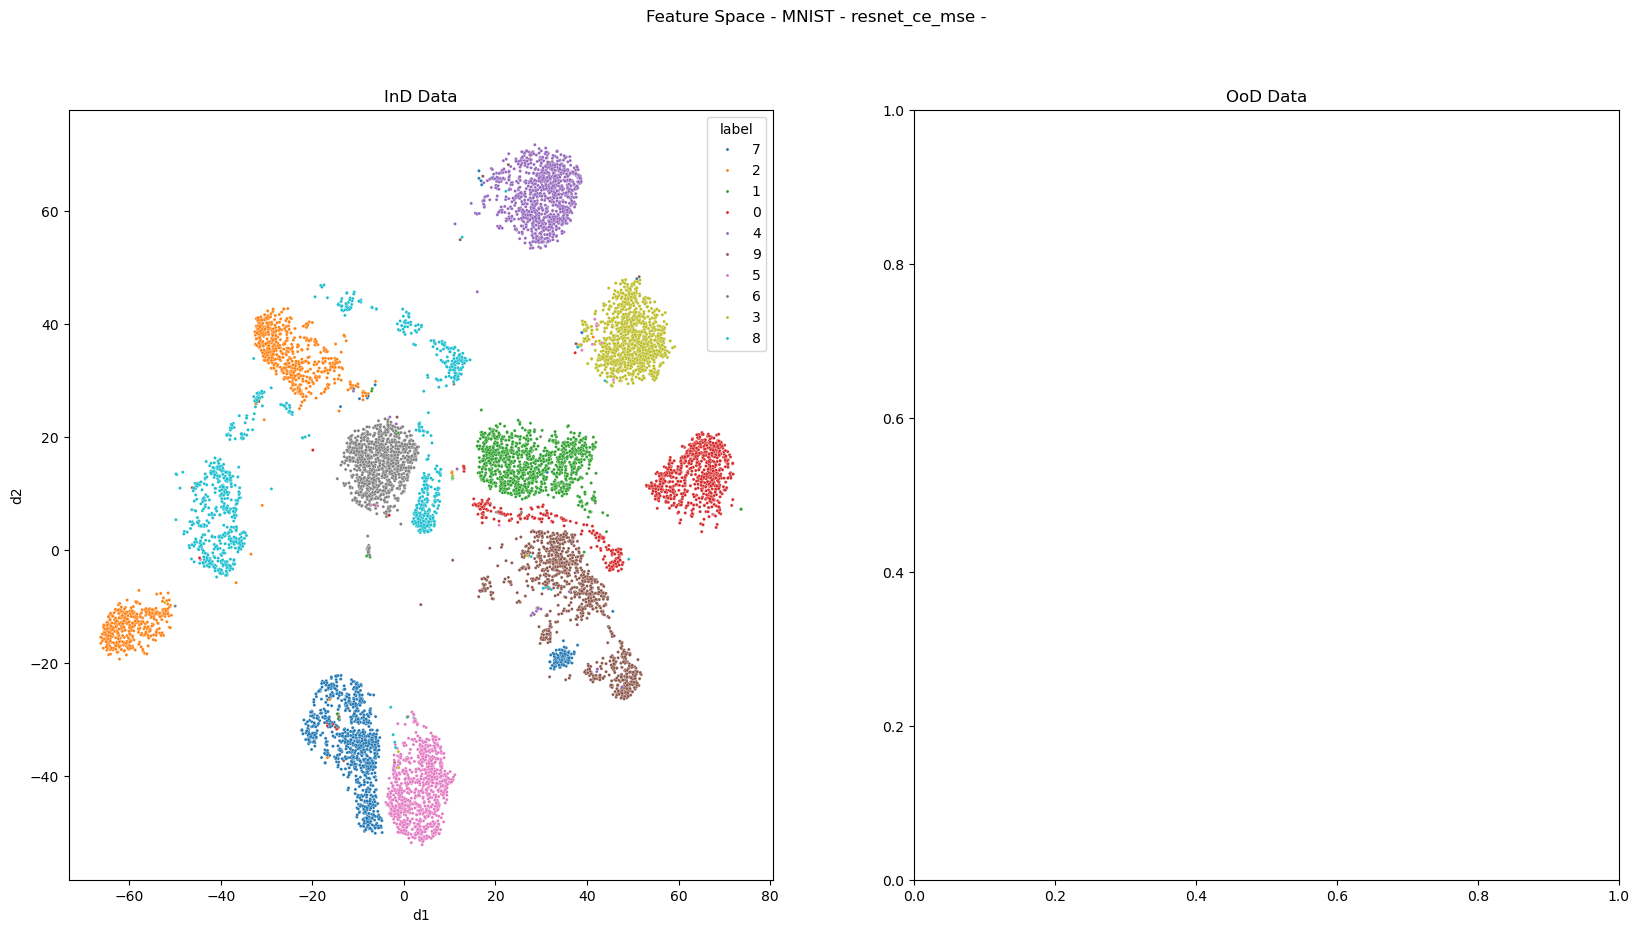

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

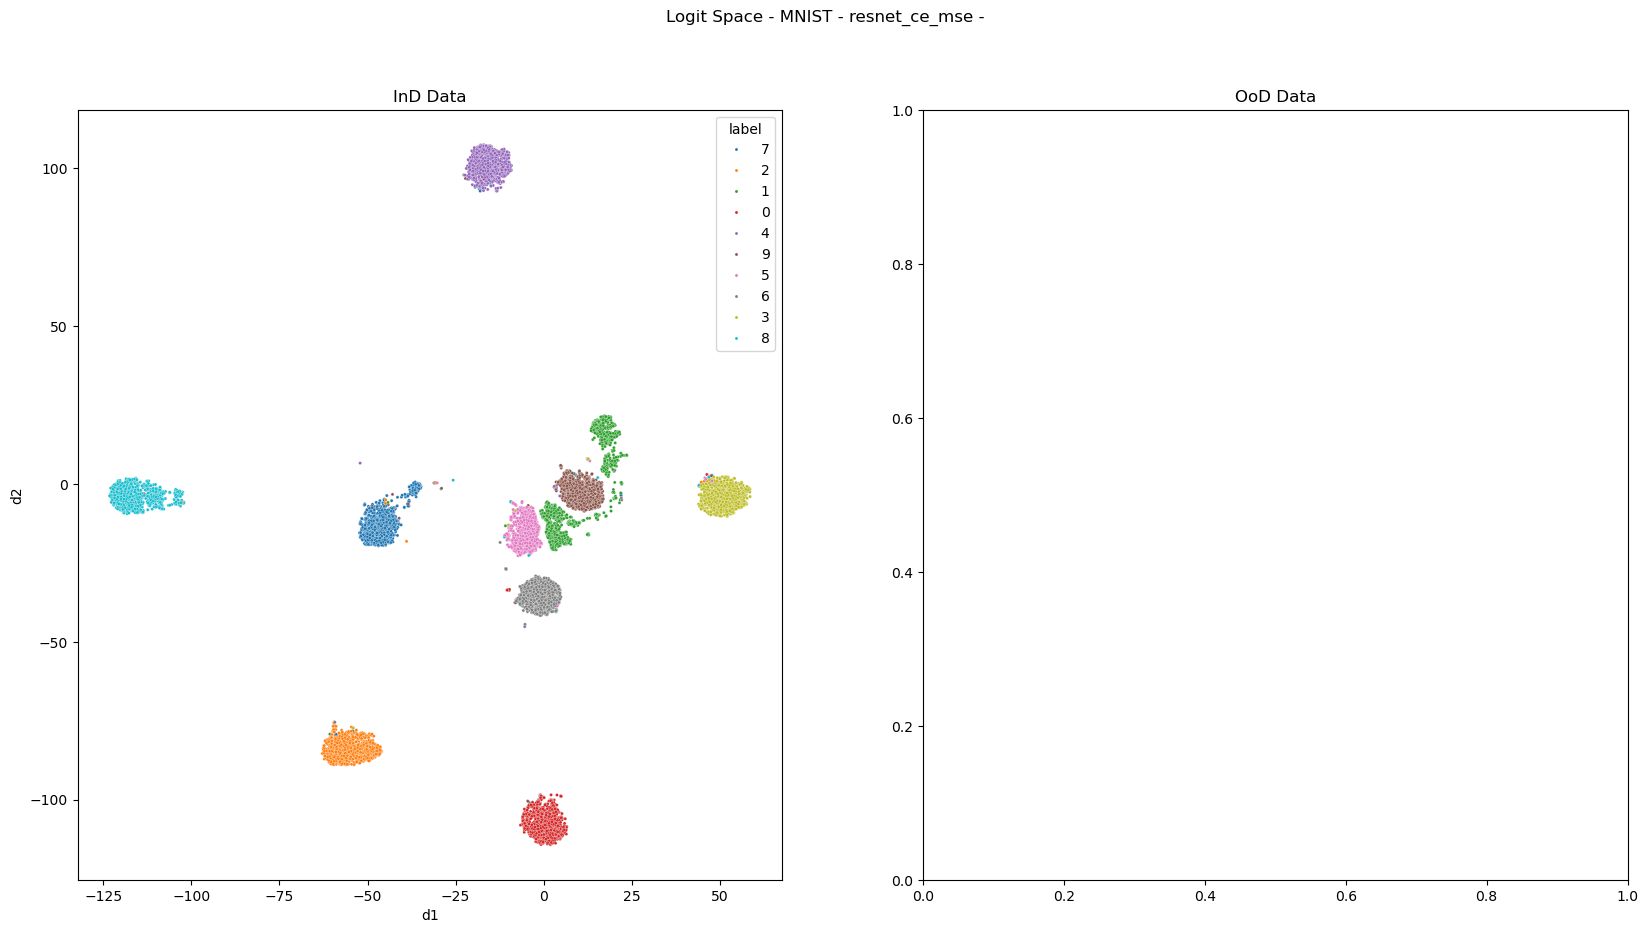

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  1.88it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.85it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  1.60it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.61it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.65it/s]

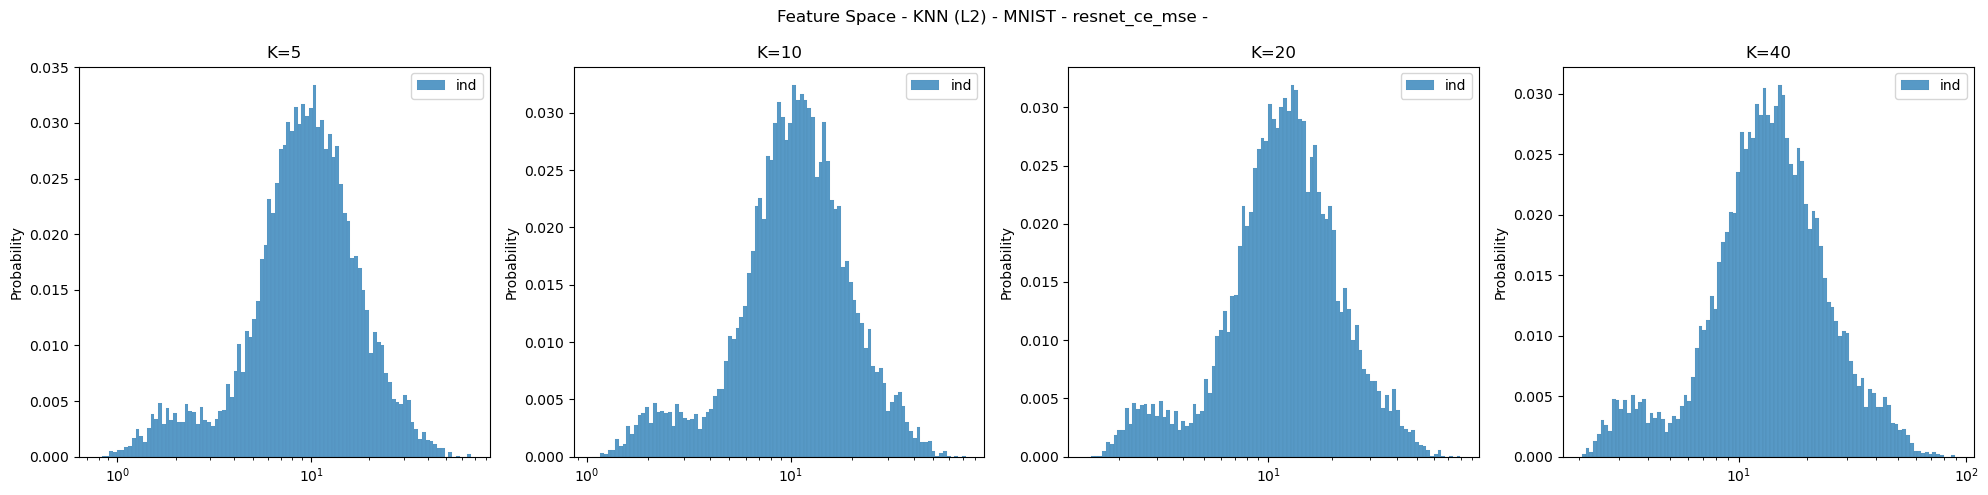

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:01,  1.96it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.93it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:01<00:00,  1.88it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.84it/s]

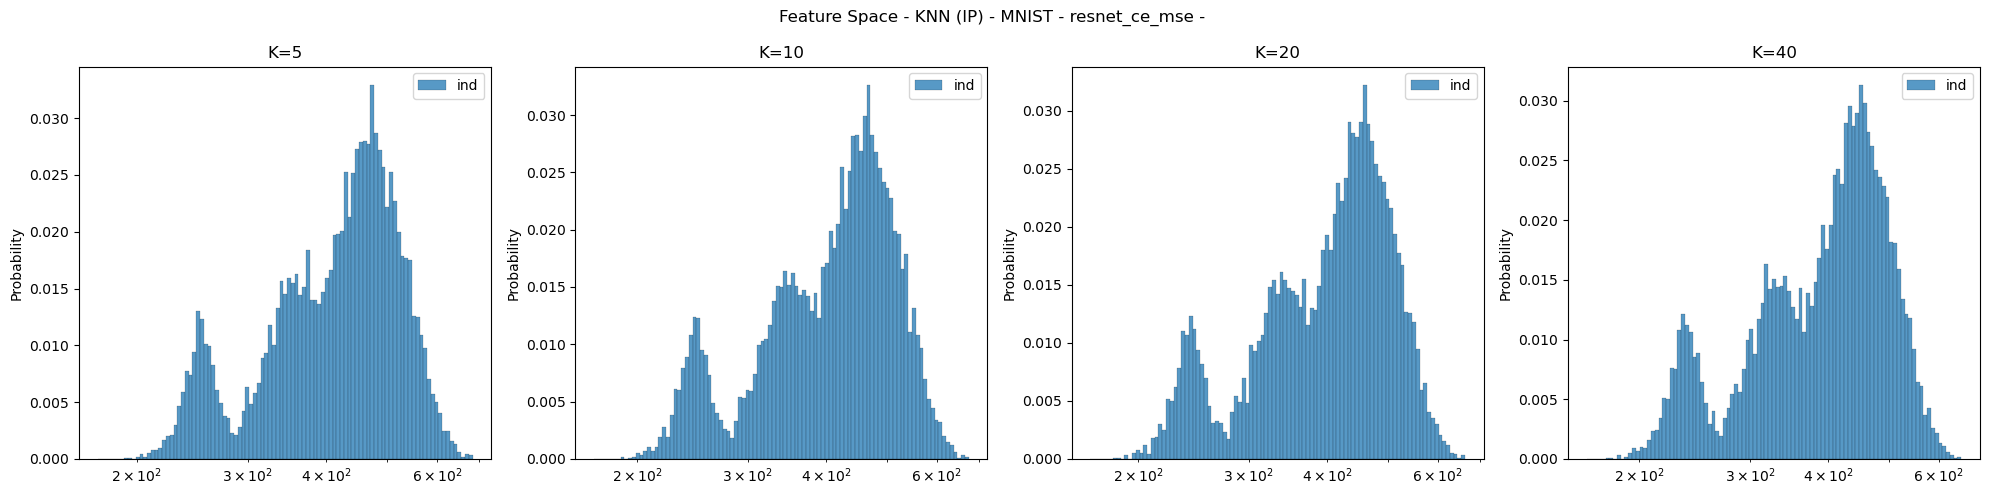

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  5.28it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  5.11it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  3.34it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.43it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.66it/s]

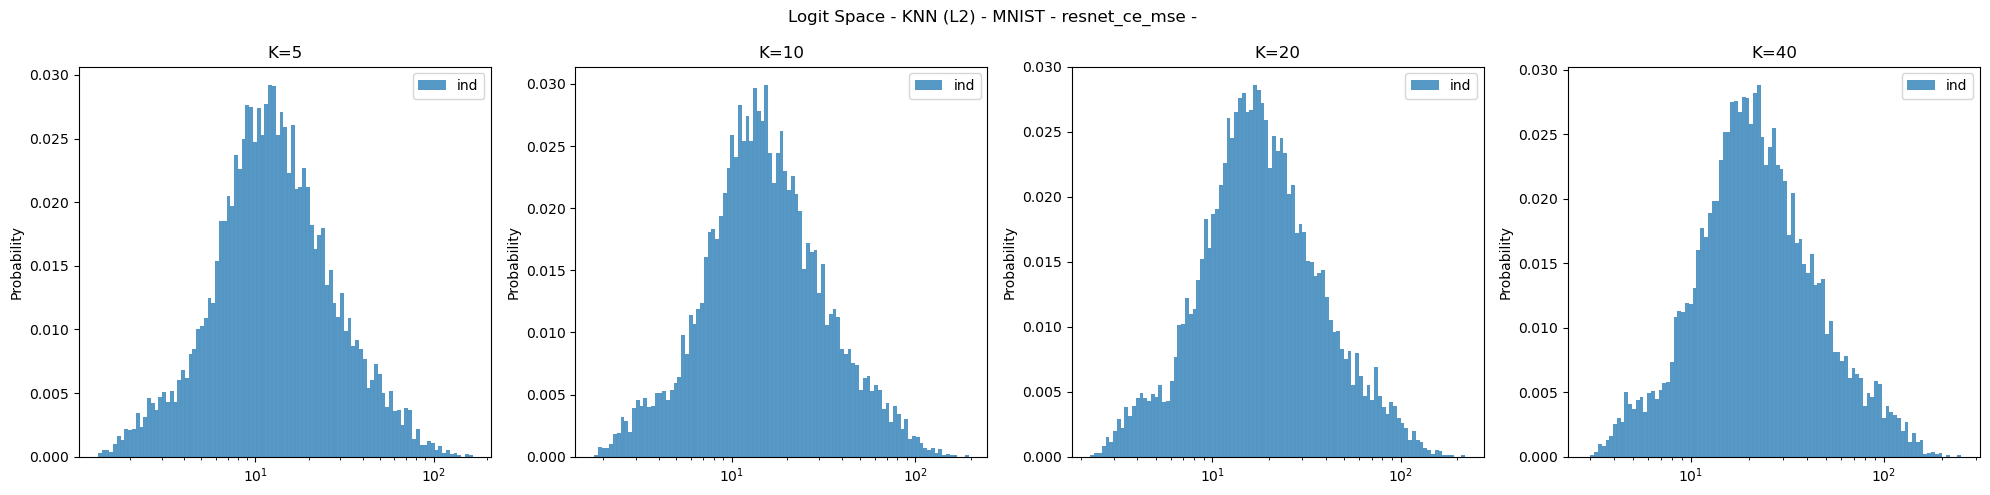

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:00,  5.78it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:00<00:00,  5.54it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:00<00:00,  5.14it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.51it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.80it/s]

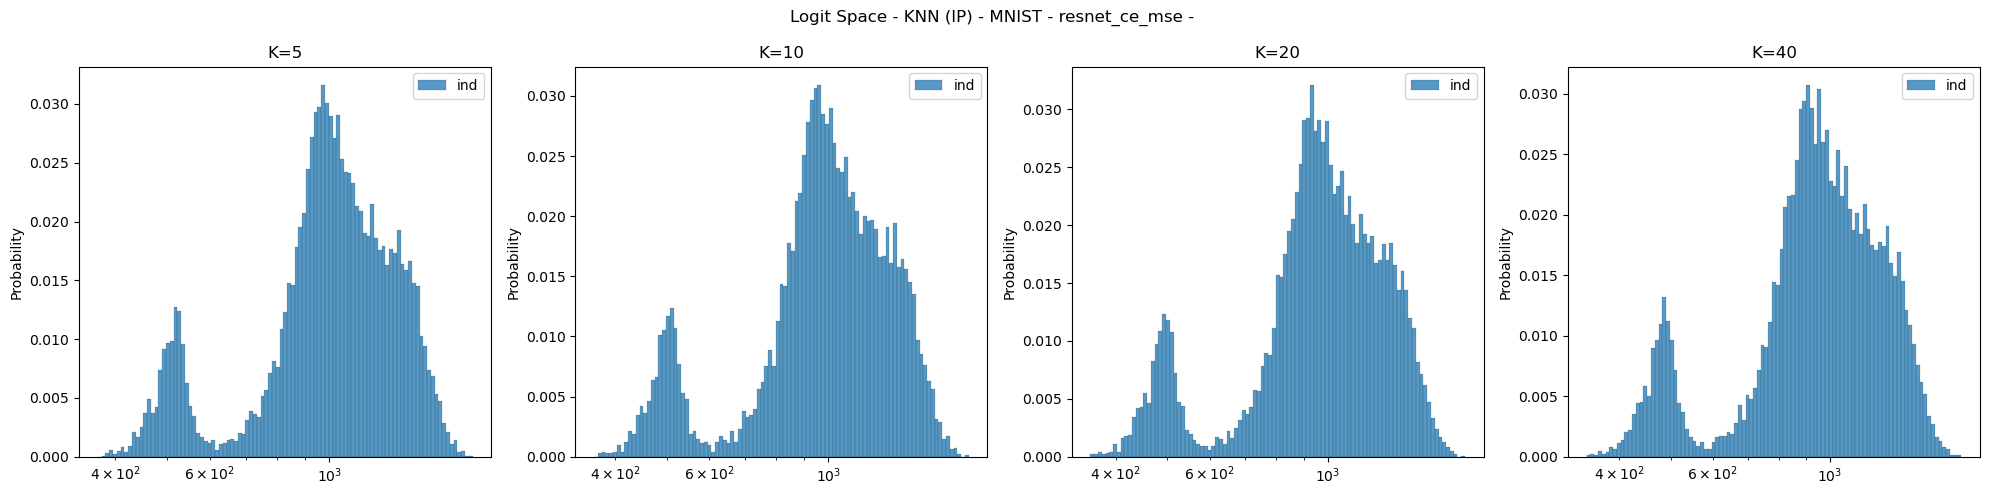

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

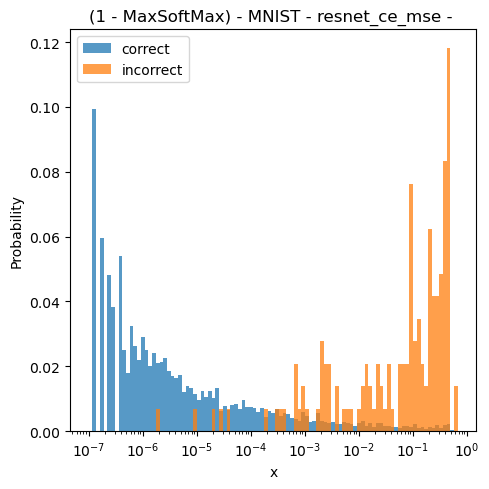

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

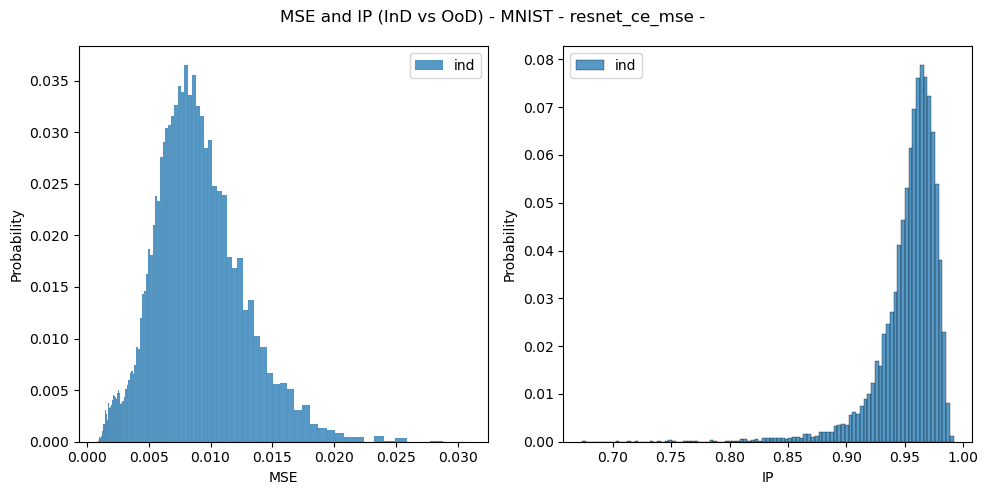

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()